In [7]:
import datetime
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.patches import Rectangle

In [8]:
csv_files = glob.glob('./data/spy-*-cleaned.csv')
dfs = []

for file in csv_files:
    print(f'appending data from {file}')
    df = pd.read_csv(file)
    dfs.append(df)

appending data from ./data/spy-2025-07-07-cleaned.csv


In [9]:
combined_df = pd.concat(dfs, ignore_index=True)

In [10]:
# See https://docs.python.org/3/library/datetime.html
# The hour is not zero padded, so %-I
combined_df['DateTime'] = pd.to_datetime(
    combined_df['Date'] + ' ' + combined_df['Time'],
    format='%m/%d/%Y %I:%M %p',
)

In [11]:
# Remove duplicates keeping the first occurrence.
clean_df = combined_df.drop_duplicates(subset=['DateTime'], keep='first')

# Sort by timestamp to ensure proper chronological order.
clean_df = clean_df.sort_values('DateTime').reset_index(drop=True)

In [12]:
clean_df.to_csv('./data/spy_combined_price_data.csv', index=False)

In [13]:
df = pd.read_csv('./data/spy_combined_price_data.csv')

df['DateTime'] = pd.to_datetime(df['DateTime'])

In [14]:
df.tail(1)

,Date,Time,Open,High,Low,Close,Volume,Simple Moving Average - SMA - SMA(20),Simple Moving Average - SMA - SMA(50),Simple Moving Average - SMA - SMA(200),"Exponential Moving Average - EMA - EMA(9,Modern)","Exponential Moving Average - EMA - EMA(61,Modern)",Relative Strength Index - RSI - RSI(14),"MACD - MACD(12,26,9)",MACD - Histogram,"MACD - Signal Line(MACD(12,26,9),9,Modern)",DateTime
2534,07/07/2025,8:00 PM,619.9799,620.0,619.9799,620.0,626,619.890105,619.825082,619.588439,619.935433,619.763928,57.707894,0.038955,0.001371,0.037584,2025-07-07 20:00:00


In [159]:
def find_closest_time_index(df, date, target_time):
    """Find the index of the closest time to target_time"""
    time_diffs = abs(df['DateTime'].dt.time.apply(lambda x: 
        datetime.datetime.combine(date, x) - 
        datetime.datetime.combine(date, target_time)
    ))
    closest_idx = time_diffs.idxmin()
    return list(df.index).index(closest_idx)

def plot_spread_analysis(df, desired_date):    
    recent_data = df[df['DateTime'].dt.date == desired_date].copy()
    
    # Get first 15 minutes (9:30 to 9:45).
    first_15min = recent_data[
        (recent_data['DateTime'].dt.time >= datetime.time(9, 30)) & 
        (recent_data['DateTime'].dt.time <= datetime.time(9, 45))
    ]
    max_15min = first_15min['High'].max()
    min_15min = first_15min['Low'].min()
    print(f'ORB: {first_15min["Time"].iloc[0]} -> {first_15min["Time"].iloc[-1]}')
    print(f'First 15min data shape: {first_15min.shape}')
    print(f'First 15min time range: {first_15min["DateTime"].min()} to {first_15min["DateTime"].max()}')
    print(first_15min[['DateTime', 'High', 'Low']].head(16))

    # Determine line color based on trend vs previous close.
    current_close = first_15min['Close'].iloc[-1]
    print(f'15min close: {current_close}')

    prev_dates = df[df['DateTime'].dt.date < desired_date]['DateTime'].dt.date.unique()
    if len(prev_dates) > 0:
        prev_date = max(prev_dates)  # Most recent date before today
        print(f'using {prev_date} as previous date')
        prev_close_data = df[df['DateTime'].dt.date == prev_date]
        prev_close = prev_close_data['Close'].iloc[-1]
        print(f'prev day close: {prev_close}')
        line_color = 'green' if current_close > prev_close else 'red'
    else:
        print('no data for previous day found')
        line_color = 'black'

    day_close = recent_data['Close'].iloc[-1]
    print(f'price at close: {day_close}')

    
    #fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), height_ratios=[3, 1])
    fig, ax1 = plt.subplots(figsize=(10, 5))
    
    # ===== MAIN CANDLESTICK CHART =====
    for i, (idx, row) in enumerate(recent_data.iterrows()):
        open_price = row['Open']
        close_price = row['Close']
        high_price = row['High']
        low_price = row['Low']
        
        # Determine candle color.
        color = 'green' if close_price > open_price else 'red'
        
        # Draw the high-low line.
        ax1.plot([i, i], [low_price, high_price], color=color, linewidth=1)
        
        # Draw the open-close rectangle.
        height = abs(close_price - open_price)
        bottom = min(open_price, close_price)
        rect = Rectangle((i-0.3, bottom), 0.6, height, facecolor=color, alpha=0.7, edgecolor=color)
        ax1.add_patch(rect)
       
    # Plot horizontal lines for first 15min high/low.
    ax1.axhline(y=max_15min, color=line_color, linestyle='-', linewidth=3, alpha=0.3, label=f'15min High: {max_15min:.2f}')
    ax1.axhline(y=min_15min, color=line_color, linestyle='-', linewidth=3, alpha=0.3, label=f'15min Low: {min_15min:.2f}')
    ax1.axhline(y=prev_close, color='black', linestyle='--', linewidth=2, alpha=0.3, label=f'prev day close: {prev_close:.2f}')


    # Calculate where 10-minute marks would be on your x-axis
    first_time = recent_data['DateTime'].iloc[0]
    last_time = recent_data['DateTime'].iloc[-1]
    
    # Convert these times to x-axis positions
    tick_times_desired = pd.date_range(
        start=first_time.floor('30min'),  
        end=last_time.ceil('30min'),      
        freq='30min'
    )
    
    tick_positions = []
    tick_labels = []
    for tick_time in tick_times_desired:
        # Find the closest actual data point to this time
        time_diffs = abs(recent_data['DateTime'] - tick_time)
        closest_idx = time_diffs.idxmin()
        
        # Convert to position in the plot (0 to len(recent_data)-1)
        position = list(recent_data.index).index(closest_idx)
        
        tick_positions.append(position)
        tick_labels.append(tick_time.strftime('%H:%M'))
    
    ax1.set_xticks(tick_positions)
    ax1.set_xticklabels(tick_labels, rotation=45)

    # Replace all the tick calculation with this:
    # Find the actual indices where 9:30 and 9:45 occur in your data
    idx_930 = recent_data[recent_data['DateTime'].dt.time == datetime.time(9, 30)].index
    idx_945 = recent_data[recent_data['DateTime'].dt.time == datetime.time(9, 45)].index
    if len(idx_930) > 0:
        pos_930 = list(recent_data.index).index(idx_930[0])
        ax1.axvline(x=pos_930, color='black', linestyle='--', linewidth=1, alpha=0.7, label='9:30 AM')
    
    if len(idx_945) > 0:
        pos_945 = list(recent_data.index).index(idx_945[0])
        ax1.axvline(x=pos_945, color='black', linestyle='--', linewidth=1, alpha=0.7, label='9:45 AM')

    pos_3pm = find_closest_time_index(recent_data, desired_date, datetime.time(15, 0))
    ax1.axvline(x=pos_3pm, color='black', linestyle='--', linewidth=1, alpha=0.7, label='3:00 PM')
    print(f'{pos_3pm=}')

    ax1.set_ylabel('Price ($)')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [160]:
df['DateTime'].iloc[0]

Timestamp('2025-07-01 16:00:00')

In [161]:
np.flip( df['DateTime'].dt.date.unique() )

array([datetime.date(2025, 7, 7), datetime.date(2025, 7, 3),
       datetime.date(2025, 7, 2), datetime.date(2025, 7, 1)], dtype=object)

ORB: 9:30 AM -> 9:45 AM
First 15min data shape: (16, 17)
First 15min time range: 2025-07-07 09:30:00 to 2025-07-07 09:45:00
                DateTime      High      Low
1939 2025-07-07 09:30:00  623.4100  623.180
1940 2025-07-07 09:31:00  623.9880  623.310
1941 2025-07-07 09:32:00  623.9550  623.490
1942 2025-07-07 09:33:00  623.5500  623.130
1943 2025-07-07 09:34:00  623.3750  623.025
1944 2025-07-07 09:35:00  623.2500  622.880
1945 2025-07-07 09:36:00  623.3200  623.125
1946 2025-07-07 09:37:00  623.2450  623.065
1947 2025-07-07 09:38:00  623.5499  623.190
1948 2025-07-07 09:39:00  623.6300  623.460
1949 2025-07-07 09:40:00  623.4900  623.320
1950 2025-07-07 09:41:00  623.5800  623.170
1951 2025-07-07 09:42:00  623.6600  623.440
1952 2025-07-07 09:43:00  623.6600  623.490
1953 2025-07-07 09:44:00  623.5300  623.420
1954 2025-07-07 09:45:00  623.6650  623.390
15min close: 623.45
using 2025-07-03 as previous date
prev day close: 625.01
price at close: 620.0
pos_3pm=594


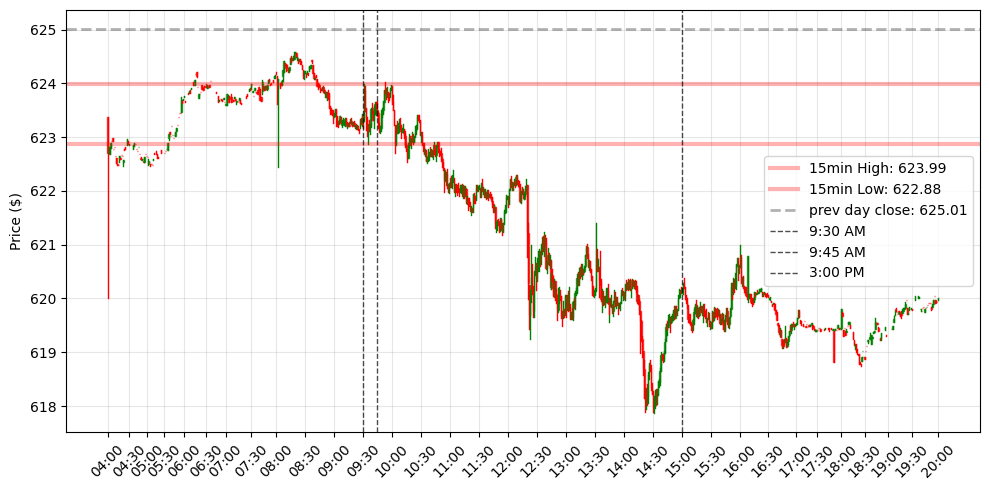

In [162]:
plot_spread_analysis(df, datetime.date(2025, 7, 7))

In [163]:
df[df['DateTime'].dt.date == datetime.date(2025, 7, 7)].iloc[593:596]

,Date,Time,Open,High,Low,Close,Volume,Simple Moving Average - SMA - SMA(20),Simple Moving Average - SMA - SMA(50),Simple Moving Average - SMA - SMA(200),"Exponential Moving Average - EMA - EMA(9,Modern)","Exponential Moving Average - EMA - EMA(61,Modern)",Relative Strength Index - RSI - RSI(14),"MACD - MACD(12,26,9)",MACD - Histogram,"MACD - Signal Line(MACD(12,26,9),9,Modern)",DateTime
2268,07/07/2025,2:59 PM,620.1350,620.2199,620.10,620.1307,89424,619.63642,619.188924,620.296087,619.919389,619.486016,71.850318,0.282478,0.049185,0.233293,2025-07-07 14:59:00
2269,07/07/2025,3:00 PM,620.1301,620.2000,620.10,620.1600,66067,619.70142,619.185924,620.287212,619.967511,619.507757,72.449863,0.287363,0.043256,0.244107,2025-07-07 15:00:00
2270,07/07/2025,3:01 PM,620.1500,620.2900,620.08,620.2700,137958,619.76592,619.186424,620.279062,620.028009,619.532346,74.634142,0.296690,0.042066,0.254624,2025-07-07 15:01:00


ORB: 9:30 AM -> 9:45 AM
First 15min data shape: (16, 17)
First 15min time range: 2025-07-03 09:30:00 to 2025-07-03 09:45:00
                DateTime     High       Low
1259 2025-07-03 09:30:00  622.600  622.4000
1260 2025-07-03 09:31:00  622.985  622.4300
1261 2025-07-03 09:32:00  623.130  622.8801
1262 2025-07-03 09:33:00  623.290  623.0600
1263 2025-07-03 09:34:00  623.370  623.0250
1264 2025-07-03 09:35:00  623.480  623.2700
1265 2025-07-03 09:36:00  623.500  623.3400
1266 2025-07-03 09:37:00  623.600  623.4500
1267 2025-07-03 09:38:00  623.570  623.4900
1268 2025-07-03 09:39:00  623.635  623.4600
1269 2025-07-03 09:40:00  623.590  623.3900
1270 2025-07-03 09:41:00  623.455  623.1900
1271 2025-07-03 09:42:00  623.330  623.1150
1272 2025-07-03 09:43:00  623.430  623.1450
1273 2025-07-03 09:44:00  623.460  623.2800
1274 2025-07-03 09:45:00  623.510  623.3300
15min close: 623.46
using 2025-07-02 as previous date
prev day close: 620.62
price at close: 625.01
pos_3pm=582


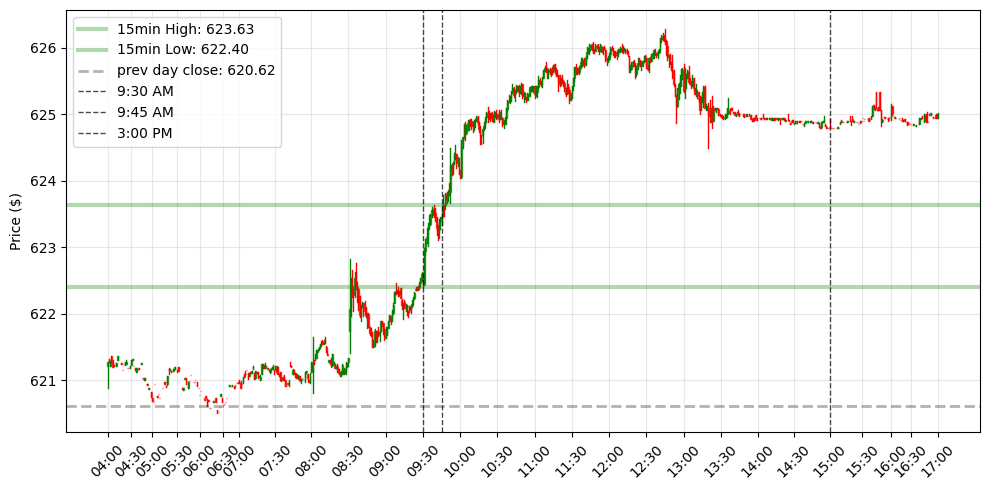

In [164]:
plot_spread_analysis(df, datetime.date(2025, 7, 3))

In [165]:
df[df['DateTime'].dt.date == datetime.date(2025, 7, 3)].iloc[581:584]

,Date,Time,Open,High,Low,Close,Volume,Simple Moving Average - SMA - SMA(20),Simple Moving Average - SMA - SMA(50),Simple Moving Average - SMA - SMA(200),"Exponential Moving Average - EMA - EMA(9,Modern)","Exponential Moving Average - EMA - EMA(61,Modern)",Relative Strength Index - RSI - RSI(14),"MACD - MACD(12,26,9)",MACD - Histogram,"MACD - Signal Line(MACD(12,26,9),9,Modern)",DateTime
1586,07/03/2025,2:59 PM,624.79,624.80,624.79,624.79,1813,624.864465,624.893158,625.353659,624.831469,624.919283,36.079407,-0.023389,-0.006845,-0.016544,2025-07-03 14:59:00
1587,07/03/2025,3:00 PM,624.81,624.93,624.80,624.80,653,624.859465,624.890358,625.348709,624.825175,624.915435,38.387499,-0.024815,-0.006617,-0.018198,2025-07-03 15:00:00
1588,07/03/2025,3:01 PM,624.79,624.79,624.79,624.79,1682,624.853970,624.887158,625.343859,624.818140,624.911389,36.950625,-0.026448,-0.006600,-0.019848,2025-07-03 15:01:00


ORB: 9:30 AM -> 9:45 AM
First 15min data shape: (16, 17)
First 15min time range: 2025-07-02 09:30:00 to 2025-07-02 09:45:00
               DateTime      High       Low
433 2025-07-02 09:30:00  617.2700  617.1800
434 2025-07-02 09:31:00  617.4900  617.1500
435 2025-07-02 09:32:00  617.3700  616.7900
436 2025-07-02 09:33:00  617.1700  616.6700
437 2025-07-02 09:34:00  617.1700  616.9100
438 2025-07-02 09:35:00  617.0600  616.6602
439 2025-07-02 09:36:00  616.9050  616.6100
440 2025-07-02 09:37:00  617.0400  616.8099
441 2025-07-02 09:38:00  617.1200  616.8950
442 2025-07-02 09:39:00  617.2000  617.0000
443 2025-07-02 09:40:00  617.2899  617.0300
444 2025-07-02 09:41:00  617.3700  617.1200
445 2025-07-02 09:42:00  617.2900  617.0700
446 2025-07-02 09:43:00  617.3372  617.1950
447 2025-07-02 09:44:00  617.2800  616.9800
448 2025-07-02 09:45:00  617.2050  616.9200
15min close: 617.135
using 2025-07-01 as previous date
prev day close: 617.929
price at close: 620.62
pos_3pm=596


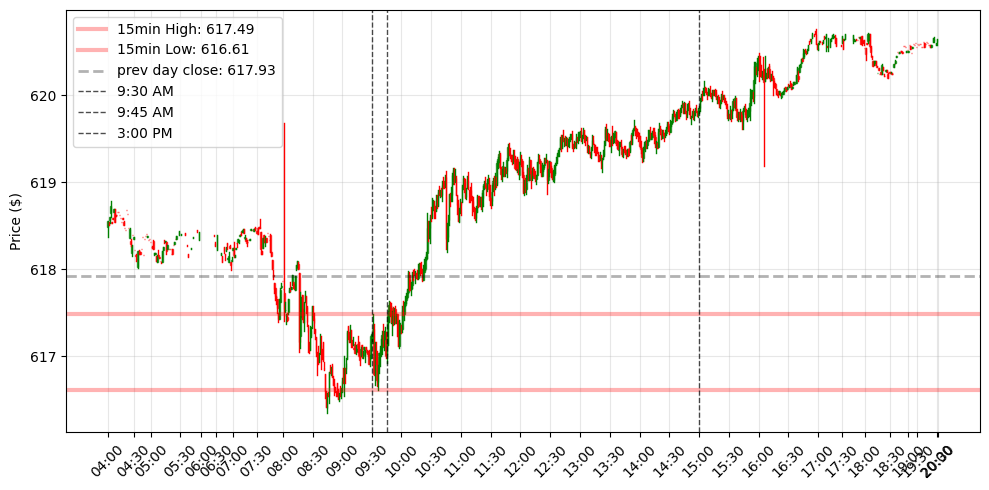

In [166]:
plot_spread_analysis(df, datetime.date(2025, 7, 2))